In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from os.path import join, basename
import os.path
from tensorflow import keras
from tensorflow.keras import layers
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import backend as K
tf.config.run_functions_eagerly(True)

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.modules.utils import _pair, _quadruple

import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Mean

import numpy as np
from skimage import color
from sklearn.cluster import KMeans
import warnings

# Load Drive



In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


# Loading Arrays




In [3]:
import os
import numpy as np

folder_path = '/content/drive/My Drive/Data Arrays/'
if os.path.exists(folder_path):

    files = os.listdir(folder_path)

    # Initialize variables to store loaded arrays
    input_images = None
    label_images = None

    # Iterate through the files and load the desired numpy arrays
    for file in files:
        if file == 'input_images_8.npy':
            file_path = os.path.join(folder_path, file)
            # Load the input images numpy array
            input_images = np.load(file_path)
            print("Successfully loaded 'input_images.npy'. Shape:", input_images.shape)
        elif file == 'label_images_8.npy':
            file_path = os.path.join(folder_path, file)
            label_images = np.load(file_path)
            print("Successfully loaded 'label_images.npy'. Shape:", label_images.shape)


    if input_images is None:
        print("File 'input_images.npy' not found in the folder.")
    if label_images is None:
        print("File 'label_images.npy' not found in the folder.")
else:
    print("Folder 'Data Arrays' not found.")


Successfully loaded 'input_images.npy'. Shape: (17, 256, 128, 256)
Successfully loaded 'label_images.npy'. Shape: (17, 256, 128, 256)


# Data Preparation

In [4]:
# input_images = input_images[:1000]
# label_images = label_images[:1000]

In [5]:
print(len(input_images))
print(len(label_images))
print(input_images[0].shape)
print(label_images[0].shape)

17
17
(256, 128, 256)
(256, 128, 256)


In [6]:
train_input, val_input, train_label, val_label = train_test_split(input_images, label_images, test_size=0.2, random_state=42)
print(len(train_input), len(train_label))
print(len(val_input), len(val_label))

13 13
4 4


In [7]:

print(val_input.shape)
print(val_label.shape)

(4, 256, 128, 256)
(4, 256, 128, 256)


In [8]:
num_classes = 3  # Number of classes
train_label_onehot = tf.keras.utils.to_categorical(train_label, num_classes=num_classes)
val_label_onehot = tf.keras.utils.to_categorical(val_label, num_classes=num_classes)


In [9]:
train_input = np.array(train_input)
val_input = np.array(val_input)

train_label_onehot = np.array(train_label_onehot)
val_label_onehot = np.array(val_label_onehot)

input_images = np.reshape(input_images, (-1, 128, 256))
label_images = np.reshape(label_images, (-1, 128, 256))
x_train = input_images
y_train = label_images

In [10]:
print(train_input.shape)
print(val_input.shape)
print(train_label_onehot.shape)
print(val_label_onehot.shape)
# print(train_label_onehot[0][0][0])

(13, 256, 128, 256)
(4, 256, 128, 256)
(13, 256, 128, 256, 3)
(4, 256, 128, 256, 3)


In [11]:
train_input = np.reshape(train_input, (-1, 128, 256))
val_input = np.reshape(val_input, (-1, 128, 256))

train_label_onehot = np.reshape(train_label_onehot, (-1, 128, 256, 3))
val_label_onehot = np.reshape(val_label_onehot, (-1, 128, 256, 3))

print(train_input.shape)
print(train_label_onehot.shape)
print(val_input.shape)
print(val_label_onehot.shape)
# print(train_label_onehot[0][0][0])

(3328, 128, 256)
(3328, 128, 256, 3)
(1024, 128, 256)
(1024, 128, 256, 3)


In [12]:
# tinp = [train_input[0]]
# tl_onht = [train_label_onehot[0]]



# for i in range(0,len(train_input),256):
#   tinp.extend(train_input[i+60:i+200])
#   tl_onht.extend(train_label_onehot[i+60:i+200])

# print(np.array(tinp).shape)
# print(np.array(tl_onht).shape)

In [13]:
# train_input = np.array(tinp.copy())
# train_label_onehot = np.array(tl_onht.copy())
# val_label = np.reshape(val_label, (-1, 128, 256))

# train_input = train_input[:500]
# train_label_onehot = train_label_onehot[:500]
# val_input = val_input[:200]
# val_label_onehot = val_label_onehot[:200]

In [14]:
print(train_input.shape)
print(train_label_onehot.shape)
print(val_input.shape)
print(val_label_onehot.shape)

(3328, 128, 256)
(3328, 128, 256, 3)
(1024, 128, 256)
(1024, 128, 256, 3)


# Custom Loss Function


In [15]:
class Custom_CE_Loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        log_y_pred = tf.math.log(y_pred)
        elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        return tf.reduce_mean(tf.reduce_sum(elements,axis=1))

In [16]:
def soft_n_cut_loss_single_k(weights, enc, batch_size, img_size, radius=5):
    channels = 1
    h, w = img_size
    p = radius

    kh, kw = radius*2 + 1, radius*2 + 1
    dh, dw = 1, 1
    encoding = F.pad(input=enc, pad=(p, p, p, p), mode='constant', value=0)

    seg = encoding.unfold(2, kh, dh).unfold(3, kw, dw)
    seg = seg.contiguous().view(batch_size, channels, -1, kh, kw)
    seg = seg.permute(0, 2, 1, 3, 4)
    seg = seg.view(-1, channels, kh, kw)

    nom = weights * seg

    nominator = torch.sum(enc * torch.sum(nom, dim=(1,2,3)).reshape(batch_size, h, w), dim=(1,2,3))
    denominator = torch.sum(enc * torch.sum(weights, dim=(1,2,3)).reshape(batch_size, h, w), dim=(1,2,3))

    return torch.div(nominator, denominator)

In [17]:
import random
ncut_loss_array = []
recon_loss_array = []

def calculate_iou(prediction, labels):
    labels = np.where(labels == 0, 0,  # Replace 0 with 0
                            np.where(labels == 128, 1,  # Replace 128 with 1
                                    np.where(labels == 255, 2, labels)))  # Replace 255 with 2

    prediction = prediction.squeeze()
    labels = labels.squeeze()
    dice = []
    iou = []
    lbls = []
    print(np.unique(labels), np.unique(prediction))
    for c in np.unique(prediction):
        intersection = np.logical_and(prediction == c, labels == c).sum()
        sum = (prediction == c).sum() + (labels == c).sum()
        union = sum - intersection
        dice.append(2 * intersection / sum)
        iou.append(intersection / union)
        lbls.append(c)

    return dice, iou, lbls

class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        input_img = input_images[10][100]
        actual_label = label_images[10][100]
        pred_mask = wnet_model.predict(np.expand_dims(input_img, axis=0))[0]  # Model expects input in batch format

        result = [[0 for i in range(len(pred_mask[0]))] for j in range(len(pred_mask))]


        for i in range(len(pred_mask)):
            for j in range(len(pred_mask[i])):
                mx = 0
                for k in range(3):
                    if pred_mask[i][j][k] > pred_mask[i][j][mx]:
                        mx = k
                result[i][j] = mx


        threshold = 0.5
        result = np.array(result)
        # print(type(actual_label), type(result))

        # Display the input image and the predicted mask
        plt.figure(figsize=(10, 5))
        plt.subplot(2, 2, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Image')

        plt.subplot(2, 2, 2)
        plt.imshow(result, cmap='gray')
        plt.title('Predicted Mask')

        plt.subplot(2, 2, 3)
        plt.imshow(actual_label, cmap='gray')
        plt.title('GT Mask')

        pass

callback = myCallback()

In [24]:

# Suppress specific sklearn warning
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

def compute_soft_ncut_loss(image1, image2, patch_size=(16, 16), stride=(8, 8), k=2):

    # image1_gray = color.rgb2gray(image1)
    # image2_gray = color.rgb2gray(image2)
    image1_gray = (image1)
    image2_gray = (image2)
    soft_ncut_loss = 0

    rows = np.arange(0, image1_gray.shape[0] - patch_size[0] + 1, stride[0])
    cols = np.arange(0, image1_gray.shape[1] - patch_size[1] + 1, stride[1])

    num_patches = len(rows) * len(cols)
    similarity_matrix = np.zeros((num_patches, num_patches))

    patch_idx = 0
    for i in rows:
        for j in cols:
            patch1 = image1_gray[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patch_idx2 = 0
            for k in rows:
                for l in cols:
                    patch2 = image2_gray[k:k+patch_size[0], l:l+patch_size[1]].flatten()
                    similarity_matrix[patch_idx, patch_idx2] = np.exp(-np.sum(np.square(patch1 - patch2)))
                    patch_idx2 += 1
            patch_idx += 1

    degree_matrix = np.diag(np.sum(similarity_matrix, axis=1))
    laplacian_matrix = degree_matrix - similarity_matrix

    _, eigenvectors = np.linalg.eigh(laplacian_matrix)

    kmeans = KMeans(n_clusters=k)
    kmeans.fit(eigenvectors[:, 1:k])

    cluster_assignments = kmeans.labels_
    sum_similarity_matrix = np.sum(similarity_matrix)
    if sum_similarity_matrix != 0:
      soft_ncut_loss = soft_ncut_loss + np.sum(similarity_matrix * (cluster_assignments[:, None] != cluster_assignments[None, :])) / sum_similarity_matrix
    else:
      soft_ncut_loss = 0

    return soft_ncut_loss



In [19]:
def normalize_output(array1):

  result = [[0 for i in range(len(array1[0]))] for j in range(len(array1))]
  for i in range(len(array1)):
      for j in range(len(array1[i])):
          mx = 0
          for k in range(3):
              if array1[i][j][k] > array1[i][j][mx]:
                  mx = k
          result[i][j] = mx
  result = np.array(result)
  return result

# Model Generation




In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(input_tensor, num_filters, kernel_size=3, separable=False):
    if separable:
        x = layers.SeparableConv2D(num_filters, kernel_size, padding="same")(input_tensor)
    else:
        x = layers.Conv2D(num_filters, kernel_size, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(input_tensor, num_filters, separable=False):
    x = conv_block(input_tensor, num_filters, separable=separable)
    x = conv_block(x, num_filters, separable=separable)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters, separable=False):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    x = layers.concatenate([x, concat_tensor])
    x = conv_block(x, num_filters, separable=separable)
    x = conv_block(x, num_filters, separable=separable)
    return x

def build_wnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    e1, p1 = encoder_block(inputs, 32)
    e2, p2 = encoder_block(p1, 64)
    e3, p3 = encoder_block(p2, 128)
    e4, p4 = encoder_block(p3, 256)

    b = conv_block(p4, 512)

    # Decoder UDec
    d4 = decoder_block(b, e4, 256)
    d3 = decoder_block(d4, e3, 128)
    d2 = decoder_block(d3, e2, 64)
    d1 = decoder_block(d2, e1, 32)

    outputs = layers.Conv2D(3, (1, 1), activation="softmax", dtype='float32')(d1)  # Adjust to 3 channels

    # Autoencoder model
    autoencoder = models.Model(inputs, outputs, name="autoencoder")

    # Encoder UEnc (for the second part of WNet)
    e1_2, p1_2 = encoder_block(outputs, 32)
    e2_2, p2_2 = encoder_block(p1_2, 64)
    e3_2, p3_2 = encoder_block(p2_2, 128)
    e4_2, p4_2 = encoder_block(p3_2, 256)

    b2 = conv_block(p4_2, 512)

    d4_2 = decoder_block(b2, e4_2, 256)
    d3_2 = decoder_block(d4_2, e3_2, 128)
    d2_2 = decoder_block(d3_2, e2_2, 64)
    d1_2 = decoder_block(d2_2, e1_2, 32)

    final_outputs = layers.Conv2D(3, (1, 1), activation="softmax", dtype='float32')(d1_2)  # Adjust to 3 channels

    wnet = models.Model(inputs, final_outputs, name="wnet")

    return wnet


In [21]:

input_shape = (128, 256, 1)
wnet_model = build_wnet(input_shape)

# Print model summary
wnet_model.summary()


Model: "wnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 128, 256, 32)         0         ['batch_normalization[0][0]

In [22]:
wnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Initialize the loss function, optimizer, and metrics
loss_fn = CategoricalCrossentropy()
optimizer = Adam()
train_loss = Mean(name='train_loss')
val_loss = Mean(name='val_loss')

epochs = 6
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label_onehot)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label_onehot)).batch(batch_size)

for epoch in range(epochs):
    print(f'Start of epoch {epoch}')
    ncut_l = 0
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = wnet_model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)

            output = wnet_model.predict(np.expand_dims(x_train[step], axis=0))[0]
            output = normalize_output(output)
            temp = compute_soft_ncut_loss(output, y_train[step])
            ncut_l += temp

            temp_tensor = tf.convert_to_tensor(temp, dtype=loss_value.dtype)
            loss_value += temp_tensor

        # print(type(loss_value), loss_value)
        grads = tape.gradient(loss_value, wnet_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, wnet_model.trainable_weights))
        train_loss(loss_value)

    ncut_l /= (step+1)
    ncut_loss_array.append(ncut_l)
    recon_loss_array.append(train_loss.result())

    for x_batch_val, y_batch_val in val_dataset:
        val_logits = wnet_model(x_batch_val, training=False)
        val_loss_value = loss_fn(y_batch_val, val_logits)
        val_loss(val_loss_value)

    print(f'Epoch {epoch}, Loss: {train_loss.result()}, N-Cut Loss: {ncut_l}, Val Loss: {val_loss.result()}')

    train_loss.reset_states()
    val_loss.reset_states()
    # callback.on_epoch_end(epoch, logs)


Start of epoch 0
1/1 [==============================] - 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


n_cutloss is  1.0770608447833282e-05
Epoch 0, Loss: 0.07643109560012817, N-Cut Loss: 1.0770608447833282e-05, Val Loss: 0.11530809849500656
Start of epoch 1
1/1 [==============================] - 0s 99ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


n_cutloss is  2.5532947894717215e-05
Epoch 1, Loss: 0.06359148025512695, N-Cut Loss: 2.5532947894717215e-05, Val Loss: 0.2679082751274109
Start of epoch 2
1/1 [==============================] - 0s 96ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


n_cutloss is  0.006153024023176055
Epoch 2, Loss: 0.06903038918972015, N-Cut Loss: 0.006153024023176055, Val Loss: 0.6440709829330444
Start of epoch 3
1/1 [==============================] - 0s 96ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


n_cutloss is  0.0001500342670251053
Epoch 3, Loss: 0.06120831519365311, N-Cut Loss: 0.0001500342670251053, Val Loss: 0.360822468996048
Start of epoch 4
1/1 [==============================] - 0s 103ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


n_cutloss is  0.00010231036852307363
Epoch 4, Loss: 0.057150669395923615, N-Cut Loss: 0.00010231036852307363, Val Loss: 0.43366825580596924
Start of epoch 5
1/1 [==============================] - 0s 101ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


n_cutloss is  0.0014453052723361632
Epoch 5, Loss: 0.05340207368135452, N-Cut Loss: 0.0014453052723361632, Val Loss: 0.5713598728179932


# Saving


In [ ]:
import tensorflow as tf

# Load the model from the saved file
model_path = '/content/drive/My Drive/wnet_model_good.h5'
wnet_model = tf.keras.models.load_model(model_path)

# Verify the model structure
# wnet_model.summary()

Model: "wnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 256, 1)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 128, 256, 32)         320       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_34 (Ba  (None, 128, 256, 32)         128       ['conv2d_36[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_34 (ReLU)             (None, 128, 256, 32)         0         ['batch_normalization_34[0]

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 313ms/step
[0 1 2] [0 1 2]
Dice score are  [0.9952752868575836, 0.8984918173066638, 0.8374884579870729]
IoU score are  [0.990595009596929, 0.8156923674499903, 0.7204130262112788]
2.438765398996511e-09


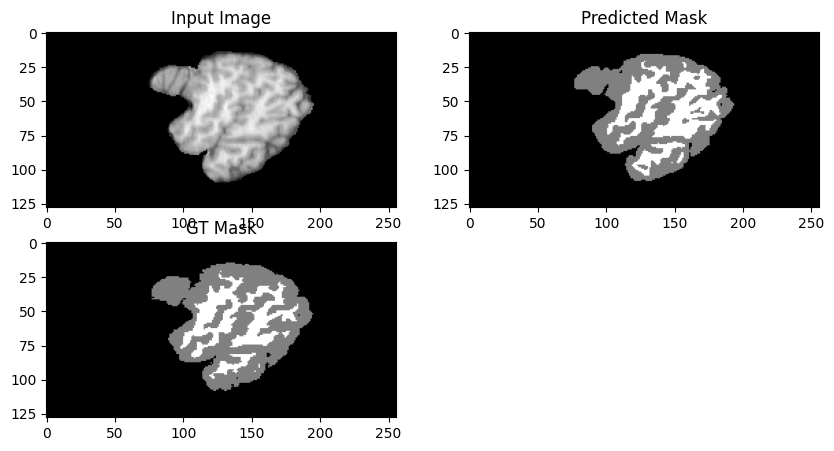

In [ ]:

input_img = input_images[10]
actual_label = label_images[10]
pred_mask = wnet_model.predict(np.expand_dims(input_img, axis=0))[0]  # Model expects input in batch format

result = [[0 for i in range(len(pred_mask[0]))] for j in range(len(pred_mask))]


for i in range(len(pred_mask)):
    for j in range(len(pred_mask[i])):
        mx = 0
        for k in range(3):
            if pred_mask[i][j][k] > pred_mask[i][j][mx]:
                mx = k
        result[i][j] = mx


threshold = 0.5
result = np.array(result)
# print(type(actual_label), type(result))

# Display the input image and the predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(input_img, cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(result, cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(actual_label, cmap='gray')
plt.title('GT Mask')

dice, iou, lbls = (calculate_iou(result, actual_label))
print('Dice score are ', dice)
print('IoU score are ',iou)

print(compute_soft_ncut_loss(result, actual_label))


In [ ]:
wnet_model.save('wnet_model_1006.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

save_path = '/content/drive/My Drive/wnet_model_1006.h5'
wnet_model.save(save_path)

print(f"Model saved to {save_path}")


Model saved to /content/drive/My Drive/wnet_model_1006.h5


# Plots


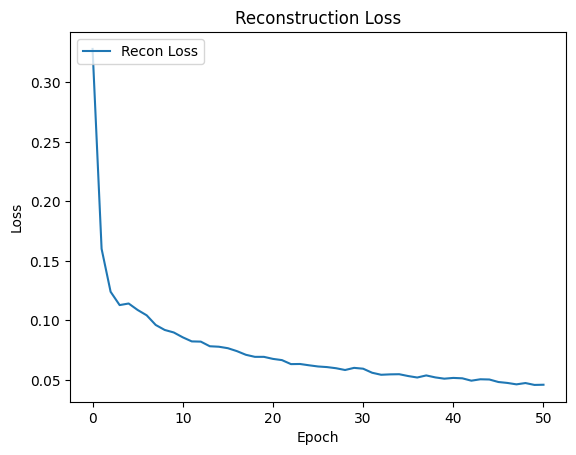

In [ ]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.plot(recon_loss_array)
plt.title('Reconstruction Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Recon Loss'], loc='upper left')
plt.show()


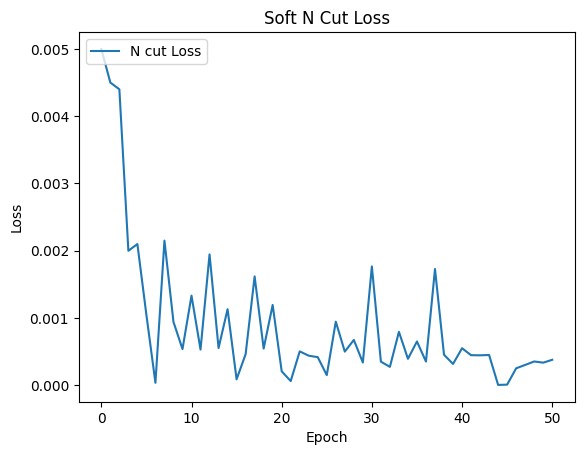

In [ ]:
plt.plot(ncut_loss_array)
plt.title('Soft N Cut Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['N cut Loss'], loc='upper left')
plt.show()


# Testing


1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


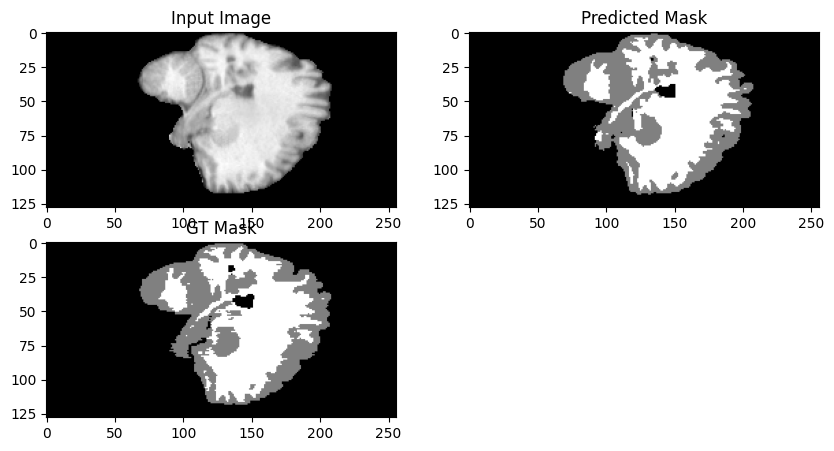

In [ ]:
inp1 = val_input[105]
lbl1 = val_label_onehot[105]
lb = val_label[105]


pred_mask = wnet_model.predict(np.expand_dims(inp1, axis=0))[0]
result = [[0 for i in range(len(pred_mask[0]))] for j in range(len(pred_mask))]


for i in range(len(pred_mask)):
    for j in range(len(pred_mask[i])):
        mx = 0
        for k in range(3):
            if pred_mask[i][j][k] > pred_mask[i][j][mx]:
                mx = k
        result[i][j] = mx

threshold = 0.5
result = np.array(result)

# Display the input image and the predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(inp1, cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(result, cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(lb, cmap='gray')
plt.title('GT Mask')



plt.show()

In [ ]:
print(type(result), type(inp1))
print(compute_soft_ncut_loss(lbl1, pred_mask))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.00041455342080502045


In [ ]:
print(len(input_images[0]))

256


1/1 [==============================] - 0s 29ms/step
(128, 256) (128, 256)


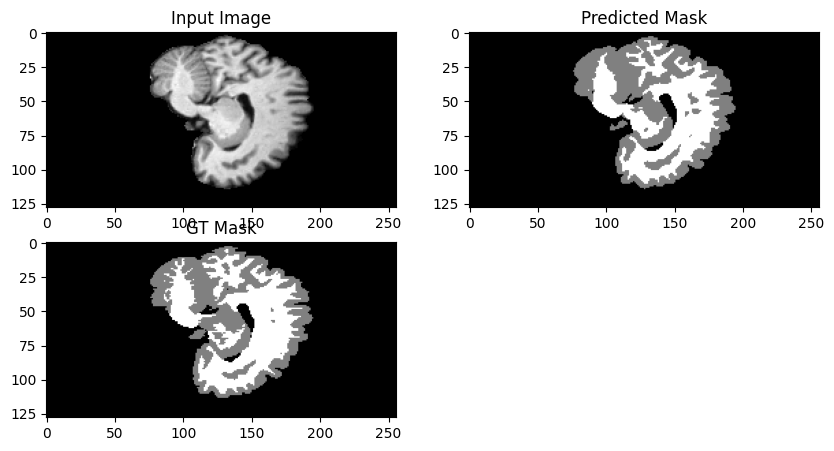

In [ ]:
inp1 = input_images[5][140]
lbl1 = label_images[5][140]
pred_mask = wnet_model.predict(np.expand_dims(inp1, axis=0))[0]
result = [[0 for i in range(len(pred_mask[0]))] for j in range(len(pred_mask))]


for i in range(len(pred_mask)):
    for j in range(len(pred_mask[i])):
        mx = 0
        for k in range(3):
            if pred_mask[i][j][k] > pred_mask[i][j][mx]:
                mx = k
        result[i][j] = mx

print(inp1.shape, lbl1.shape)

threshold = 0.5
result = np.array(result)

# Display the input image and the predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(inp1, cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(result, cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(lbl1, cmap='gray')
plt.title('GT Mask')

plt.show()

1/1 [==============================] - 0s 31ms/step


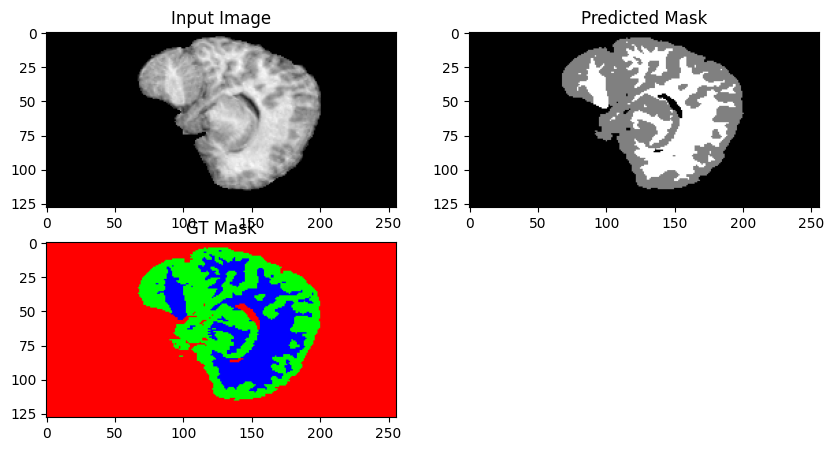

In [ ]:
inp1 = train_input[50]
lbl1 = train_label_onehot[50]

pred_mask = wnet_model.predict(np.expand_dims(inp1, axis=0))[0]
result = [[0 for i in range(len(pred_mask[0]))] for j in range(len(pred_mask))]


for i in range(len(pred_mask)):
    for j in range(len(pred_mask[i])):
        mx = 0
        for k in range(3):
            if pred_mask[i][j][k] > pred_mask[i][j][mx]:
                mx = k
        result[i][j] = mx


threshold = 0.5
result = np.array(result)

# Display the input image and the predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(inp1, cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(result, cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(lbl1, cmap='gray')
plt.title('GT Mask')

plt.show()

In [ ]:

iou_arr = []
dice_arr = []

for k in range(len(val_input)):
  inp1 = val_input[k]
  lbl1 = val_label[k]

  pred_mask = wnet_model.predict(np.expand_dims(inp1, axis=0))[0]
  result = [[0 for i in range(len(pred_mask[0]))] for j in range(len(pred_mask))]


  for i in range(len(pred_mask)):
      for j in range(len(pred_mask[i])):
          mx = 0
          for k in range(3):
              if pred_mask[i][j][k] > pred_mask[i][j][mx]:
                  mx = k
          result[i][j] = mx


  threshold = 0.5
  result = np.array(result)
  dice,iou,lbs = calculate_iou(result, lbl1)
  if len(lbs) == 1 or len(lbs) == 2: continue
  dice_arr.append(dice)
  iou_arr.append(iou)



1/1 [==============================] - 0s 55ms/step
[0] [0]
1/1 [==============================] - 0s 46ms/step
[0] [0]
1/1 [==============================] - 0s 39ms/step
[0] [0]
1/1 [==============================] - 0s 44ms/step
[0] [0]
1/1 [==============================] - 0s 46ms/step
[0] [0]
1/1 [==============================] - 0s 27ms/step
[0] [0]
1/1 [==============================] - 0s 28ms/step
[0] [0]
1/1 [==============================] - 0s 27ms/step
[0] [0]
1/1 [==============================] - 0s 32ms/step
[0] [0]
1/1 [==============================] - 0s 26ms/step
[0] [0]
1/1 [==============================] - 0s 27ms/step
[0] [0]
1/1 [==============================] - 0s 28ms/step
[0] [0]
1/1 [==============================] - 0s 33ms/step
[0] [0]
1/1 [==============================] - 0s 31ms/step
[0] [0]
1/1 [==============================] - 0s 26ms/step
[0] [0]
1/1 [==============================] - 0s 28ms/step
[0] [0]
1/1 [==============================] - 0

In [ ]:
len(dice_arr)
# dice_arr
dice_arr_np = np.array(dice_arr)

# Calculate the mean of each column
col1_mean = np.mean(dice_arr_np[:, 0])
col2_mean = np.mean(dice_arr_np[:, 1])
col3_mean = np.mean(dice_arr_np[:, 2])

print("Dice Background", col1_mean)
print("Dice Grey Matter", col2_mean)
print("Dice White Matter", col3_mean)

Dice Background 0.9944246878499485
Dice Grey Matter 0.9175158492393759
Dice White Matter 0.8239342409880749


In [ ]:
len(iou_arr)

iou_arr_np = np.array(iou_arr)

# Calculate the mean of each column
col1_mean = np.mean(iou_arr_np[:, 0])
col2_mean = np.mean(iou_arr_np[:, 1])
col3_mean = np.mean(iou_arr_np[:, 2])

print("IoU Background", col1_mean)
print("IoU Grey Matter", col2_mean)
print("IoU White Matter", col3_mean)

IoU Background 0.9889385831087228
IoU Grey Matter 0.8494852299331195
IoU White Matter 0.7353593389757547


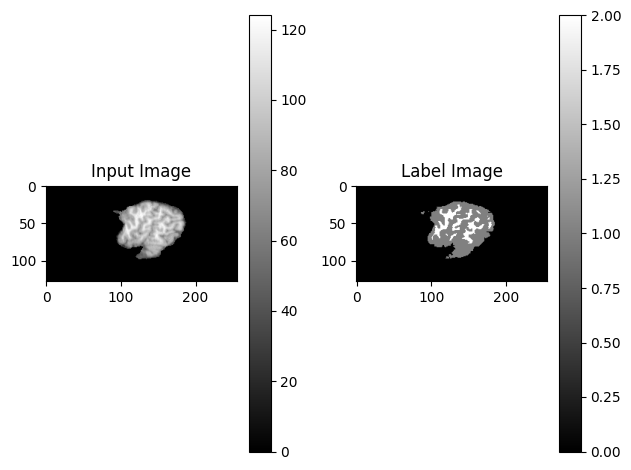

In [ ]:
import matplotlib.pyplot as plt

# Plotting the input image
plt.subplot(1, 2, 1)
plt.imshow(inp1, cmap='gray')
plt.title('Input Image')
plt.colorbar()

# Plotting the label image
plt.subplot(1, 2, 2)
plt.imshow(lbl1, cmap='gray')
plt.title('Label Image')
plt.colorbar()

plt.tight_layout()
plt.show()


# Dice loss Model

In [ ]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
history = wnet_model.fit(train_input, train_label_onehot,validation_data=(val_input, val_label_onehot),batch_size=8,epochs=3,shuffle=True)

Epoch 1/3


/opt/homebrew/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


416/416 [==============================] - 355s 854ms/step - loss: 0.1307 - dice_coef: 0.8693 - accuracy: 0.8765 - val_loss: 0.1270 - val_dice_coef: 0.8730 - val_accuracy: 0.8730
Epoch 2/3
416/416 [==============================] - 367s 882ms/step - loss: 0.1237 - dice_coef: 0.8763 - accuracy: 0.8763 - val_loss: 0.1270 - val_dice_coef: 0.8730 - val_accuracy: 0.8730
Epoch 3/3
416/416 [==============================] - 372s 895ms/step - loss: 0.1237 - dice_coef: 0.8763 - accuracy: 0.8763 - val_loss: 0.1270 - val_dice_coef: 0.8730 - val_accuracy: 0.8730


(128, 256, 1)
1/1 [==============================] - 0s 128ms/step
(128, 256, 3)
[1.0000000e+00 1.2470302e-21 1.7166849e-20]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


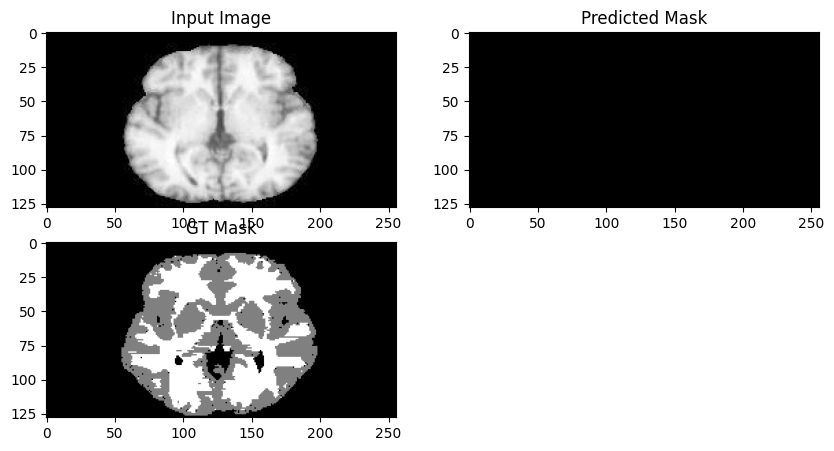

In [ ]:
# Load a single input image
IoU_array = []
num = 130
num = str(num).zfill(4)

input_image_path = '/Users/aditya/Desktop/My Computer/AIIMS/WNet-master 3/Input/Cl1/image.0001.' + num + '.jpg'
input_img = load_img(input_image_path, color_mode='grayscale')
input_img_array = img_to_array(input_img)   # Normalize the input image
actual_label = load_img('/Users/aditya/Desktop/My Computer/AIIMS/WNet-master 3/Label/One hot encoded Label/one_hot_' + num + '.png', color_mode='grayscale')
actual_label = img_to_array(actual_label)
actual_label = actual_label.reshape(128, 256)

print(input_img_array.shape)

# Predict the segmentation mask
pred_mask = wnet_model.predict(np.expand_dims(input_img_array, axis=0))[0]  # Model expects input in batch format
print(pred_mask.shape)
print(pred_mask[0][0])
print(type(pred_mask[0][0]))

result = [[0 for i in range(len(pred_mask[0]))] for j in range(len(pred_mask))]


for i in range(len(pred_mask)):
    for j in range(len(pred_mask[i])):
        mx = 0
        for k in range(3):
            if pred_mask[i][j][k] > pred_mask[i][j][mx]:
                mx = k
        result[i][j] = mx


threshold = 0.5
result = np.array(result)
print(type(actual_label), type(result))

# Display the input image and the predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(input_img, cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(result, cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 2, 3)
plt.imshow(actual_label, cmap='gray')
plt.title('GT Mask')

plt.show()

In [ ]:
print(calculate_iou(result, actual_label))

[0. 1. 2.] [0]
([0.7592578568723968], [0.6119384765625], [0])
